# Deep Network Compression via Low-Rank Matrix Factorization

## Overview
This analysis demonstrates how **Singular Value Decomposition (SVD)** can be leveraged to reduce computational burden in deep neural networks. Specifically, we'll compress a ResNet-18 architecture trained on CIFAR-10 by replacing dense layers with approximated low-rank factorizations.

## Experimental Pipeline
- **Eigenvalue Inspection:** Examining the spectral characteristics of weight matrices to identify redundancy patterns
- **Matrix Factorization:** Substituting original layers with their SVD reconstructions (tested at 0%, 50%, and 80% compression)
- **Performance Evaluation:** Quantifying the impact on model capacity, inference latency, and classification accuracy (before and after fine-tuning)

In [1]:
# Required Libraries & Dependencies
import time
import copy
import warnings
import pickle
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning Stack
import torch
import torch.nn as nn
import torch.optim as optim

# Computer Vision Utilities
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

# Configuration
%matplotlib inline
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (11, 7)

# Computational Device Selection
compute_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Compute Environment: {compute_device}")

# Error Suppression
warnings.filterwarnings('ignore')

Compute Environment: cpu


In [2]:
# ==============================================================================
# Data Loading (CIFAR-10 from Local Storage)
# ==============================================================================

BATCH_SZ = 128

# Transformation Pipeline for Training
train_transforms = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.4914, 0.4822, 0.4465),
        std=(0.2023, 0.1994, 0.2010)
    ),
])

# Transformation Pipeline for Testing
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.4914, 0.4822, 0.4465),
        std=(0.2023, 0.1994, 0.2010)
    ),
])

print("Initializing dataset from local repository...")

# Load from local pickle files (CIFAR-10)
def load_cifar10_batch(filename):
    with open(filename, 'rb') as f:
        data_dict = pickle.load(f, encoding='bytes')
    return data_dict[b'data'], data_dict[b'labels']

def build_cifar10_dataset(data_folder):
    X_train, y_train = [], []
    for batch_num in range(1, 6):
        batch_file = os.path.join(data_folder, f'data_batch_{batch_num}')
        x_batch, y_batch = load_cifar10_batch(batch_file)
        X_train.extend(x_batch)
        y_train.extend(y_batch)
    
    X_test, y_test = load_cifar10_batch(os.path.join(data_folder, 'test_batch'))
    
    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)

# Custom Dataset Wrapper
class CIFARDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform=None):
        # CIFAR-10 stores data as (N, 3072) where 3072 = 3 * 32 * 32
        # Reshape to (N, 3, 32, 32) and normalize to [0, 1]
        self.images = images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1).astype(np.uint8)
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        # Image is now in HWC format as uint8
        img = self.images[idx]
        if self.transform:
            from PIL import Image
            img = Image.fromarray(img)
            img = self.transform(img)
        label = self.labels[idx]
        return img, label

# Build datasets from local files
data_path = './data/cifar-10-batches-py'
X_tr, y_tr, X_te, y_te = build_cifar10_dataset(data_path)

train_dataset = CIFARDataset(X_tr, y_tr, transform=train_transforms)
test_dataset = CIFARDataset(X_te, y_te, transform=test_transforms)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SZ, shuffle=True, num_workers=0
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BATCH_SZ, shuffle=False, num_workers=0
)

print(f"Training samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")

# ==============================================================================
# Model Architecture Setup
# ==============================================================================

def initialize_resnet_backbone():
    """Instantiate ResNet-18 with ImageNet pretraining and adapt for CIFAR-10"""
    backbone = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    # Replace final classification head
    in_features = backbone.fc.in_features
    backbone.fc = nn.Linear(in_features, 10)
    return backbone

net = initialize_resnet_backbone().to(compute_device)

# ==============================================================================
# Training & Evaluation Functions
# ==============================================================================

def train_epoch(net, num_epochs=1, learning_rate=0.001):
    """Train network with Adam optimizer"""
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    net.train()
    
    for epoch_idx in range(num_epochs):
        cumulative_loss = 0.0
        for batch_x, batch_y in train_dataloader:
            batch_x, batch_y = batch_x.to(compute_device), batch_y.to(compute_device)
            
            optimizer.zero_grad()
            predictions = net(batch_x)
            training_loss = loss_fn(predictions, batch_y)
            training_loss.backward()
            optimizer.step()
            
            cumulative_loss += training_loss.item()

def compute_test_accuracy(net):
    """Evaluate accuracy on test set"""
    net.eval()
    match_count = 0
    total_samples = 0
    
    with torch.no_grad():
        for batch_x, batch_y in test_dataloader:
            batch_x, batch_y = batch_x.to(compute_device), batch_y.to(compute_device)
            logits = net(batch_x)
            _, predictions = torch.max(logits, dim=1)
            total_samples += batch_y.shape[0]
            match_count += (predictions == batch_y).sum().item()
    
    accuracy_pct = (100.0 * match_count) / total_samples
    return accuracy_pct

print("Baseline training (1 epoch)...")
train_epoch(net, num_epochs=1)
baseline_performance = compute_test_accuracy(net)
print(f"Baseline Test Accuracy: {baseline_performance:.2f}%")

Initializing dataset from local repository...
Training samples: 50000, Test samples: 10000
Baseline training (1 epoch)...
Baseline Test Accuracy: 70.93%


Convolutional Layer Matrix Dimensions: (128, 576)
Fully Connected Layer Matrix Dimensions: (10, 512)


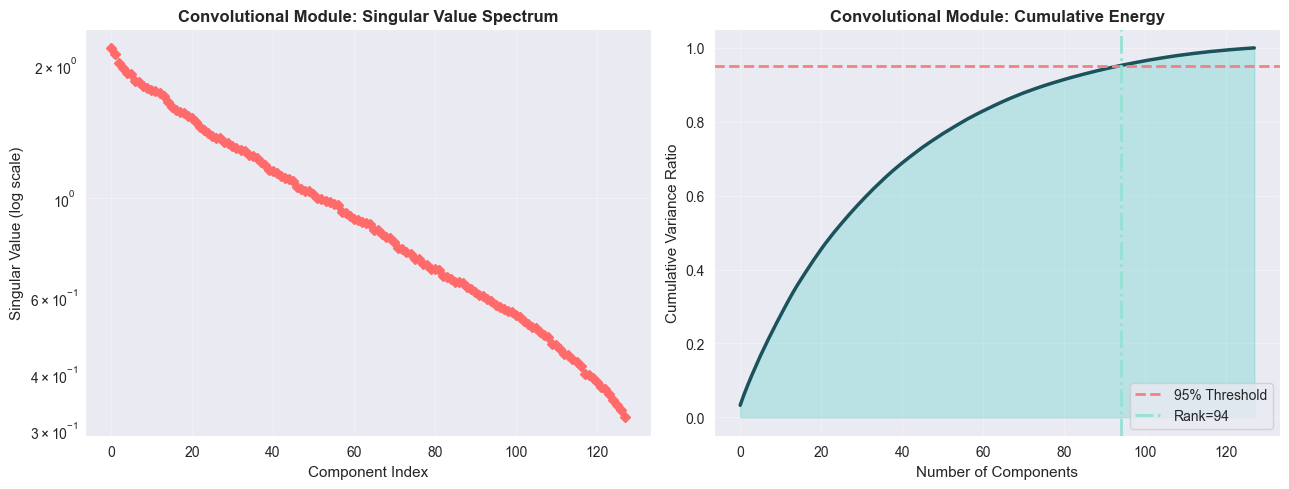

[Convolutional Module] Sufficient rank to capture 95%: 94/128


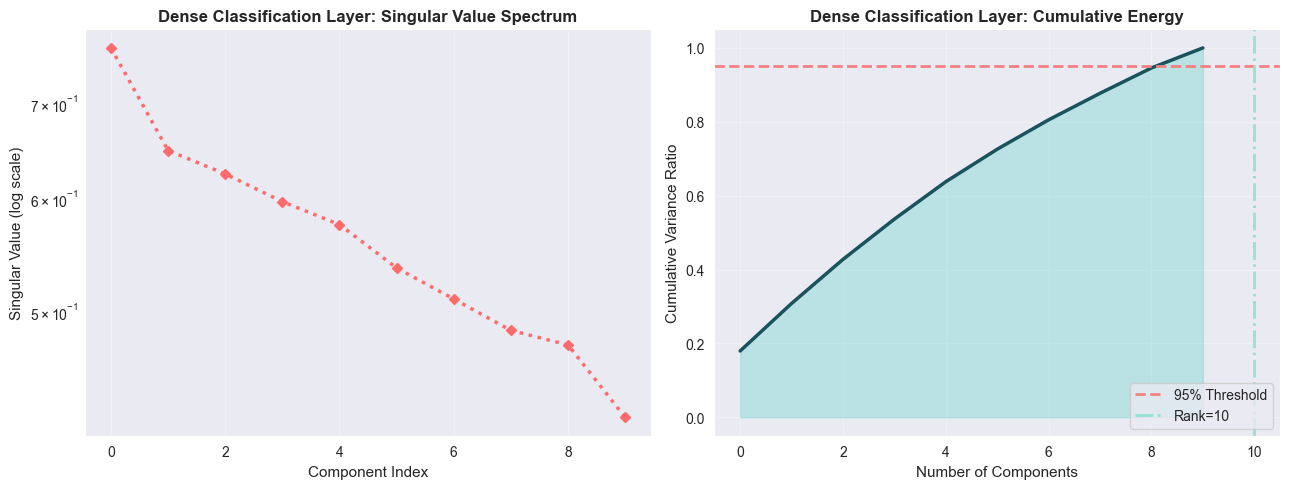

[Dense Classification Layer] Sufficient rank to capture 95%: 10/10


In [3]:
# ==============================================================================
# Spectral Decomposition & Redundancy Analysis
# ==============================================================================

# Extract weight matrices
w_conv = net.layer2[0].conv1.weight.data.cpu()
conv_matrix = w_conv.view(w_conv.shape[0], -1).numpy()

w_fc = net.fc.weight.data.cpu().numpy()

print(f"Convolutional Layer Matrix Dimensions: {conv_matrix.shape}")
print(f"Fully Connected Layer Matrix Dimensions: {w_fc.shape}")

def analyze_singular_spectrum(weight_matrix, component_name):
    """
    Decompose matrix and visualize its singular value spectrum.
    Identifies what rank is needed to capture 95% of variance.
    """
    # Compute SVD
    U, singular_vals, Vt = np.linalg.svd(weight_matrix, full_matrices=False)
    
    # Calculate variance cumulation
    sv_squared = singular_vals ** 2
    cumulative_variance = np.cumsum(sv_squared) / np.sum(sv_squared)
    
    # Find rank for 95% variance preservation
    rank_95 = np.searchsorted(cumulative_variance, 0.95) + 1
    
    # Visualization with different style
    fig, axes = plt.subplots(1, 2, figsize=(13, 5))
    
    # Plot 1: Singular value decay
    axes[0].semilogy(singular_vals, marker='D', linestyle=':', 
                     color='#FF6B6B', linewidth=2.5, markersize=5)
    axes[0].set_title(f'{component_name}: Singular Value Spectrum', 
                      fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Component Index', fontsize=11)
    axes[0].set_ylabel('Singular Value (log scale)', fontsize=11)
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Cumulative energy
    axes[1].fill_between(range(len(cumulative_variance)), cumulative_variance, 
                         alpha=0.3, color='#4ECDC4')
    axes[1].plot(cumulative_variance, linewidth=2.5, color='#1A535C')
    axes[1].axhline(0.95, color='#F38181', linestyle='--', 
                    linewidth=2, label='95% Threshold')
    axes[1].axvline(rank_95, color='#95E1D3', linestyle='-.', 
                    linewidth=2, label=f'Rank={rank_95}')
    axes[1].set_title(f'{component_name}: Cumulative Energy', 
                      fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Number of Components', fontsize=11)
    axes[1].set_ylabel('Cumulative Variance Ratio', fontsize=11)
    axes[1].legend(loc='lower right', fontsize=10)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"[{component_name}] Sufficient rank to capture 95%: {rank_95}/{len(singular_vals)}")
    return rank_95

_ = analyze_singular_spectrum(conv_matrix, "Convolutional Module")
_ = analyze_singular_spectrum(w_fc, "Dense Classification Layer")

In [4]:
# ==============================================================================
# Low-Rank Factorization Implementation
# ==============================================================================

def factorize_dense_layer_via_svd(linear_module, compression_percentage):
    """
    Approximate a linear layer using truncated SVD.
    Input: W (out_features × in_features)
    Output: Two sequential linear layers representing W ≈ U_k @ diag(sqrt(S_k)) @ diag(sqrt(S_k)) @ V_k^T
    """
    weight_matrix = linear_module.weight.data
    bias_vector = linear_module.bias.data if linear_module.bias is not None else None
    
    output_sz, input_sz = weight_matrix.shape
    total_params = output_sz * input_sz
    compressed_params = (1.0 - compression_percentage) * total_params
    
    # Calculate bottleneck dimension
    bottleneck_dim = int(compressed_params / (input_sz + output_sz))
    bottleneck_dim = max(1, min(bottleneck_dim, min(output_sz, input_sz)))
    
    # Perform SVD decomposition
    U, sigma, Vh = torch.linalg.svd(weight_matrix, full_matrices=False)
    
    # Truncate to k components
    U_trunc = U[:, :bottleneck_dim]
    sigma_trunc = sigma[:bottleneck_dim]
    Vh_trunc = Vh[:bottleneck_dim, :]
    
    # Scale singular values
    sigma_sqrt = torch.diag(torch.sqrt(sigma_trunc))
    
    # Create factorization: W ≈ (U @ sqrt(Σ)) @ (sqrt(Σ) @ V^T)
    left_weights = torch.matmul(sigma_sqrt, Vh_trunc)
    right_weights = torch.matmul(U_trunc, sigma_sqrt)
    
    # Create new layer structure
    projection_layer = nn.Linear(input_sz, bottleneck_dim, bias=False)
    reconstruction_layer = nn.Linear(bottleneck_dim, output_sz, bias=True)
    
    projection_layer.weight.data = left_weights
    reconstruction_layer.weight.data = right_weights
    if bias_vector is not None:
        reconstruction_layer.bias.data = bias_vector
    
    return nn.Sequential(projection_layer, reconstruction_layer)

def compress_network(original_net, compression_rate):
    """Apply SVD compression to fully connected layers of network"""
    compressed_net = copy.deepcopy(original_net)
    if compression_rate > 0:
        compressed_net.fc = factorize_dense_layer_via_svd(
            compressed_net.fc, compression_rate
        )
    return compressed_net.to(compute_device)

In [5]:
# ==============================================================================
# Comprehensive Benchmark Experiments
# ==============================================================================

def benchmark_inference_speed(net, input_tensor, num_iterations=50):
    """
    Measure inference latency on CPU.
    """
    net.to('cpu')
    net.eval()
    input_tensor = input_tensor.to('cpu')
    
    # Warm up GPU cache
    with torch.no_grad():
        net(input_tensor)
    
    # Time multiple forward passes
    start_time = time.perf_counter()
    with torch.no_grad():
        for _ in range(num_iterations):
            _ = net(input_tensor)
    end_time = time.perf_counter()
    
    avg_latency_ms = ((end_time - start_time) / num_iterations) * 1000
    return avg_latency_ms

# Experiment configuration
compression_levels = [0.0, 0.50, 0.80]
experiment_results = []

print("=" * 70)
print("COMPRESSION EVALUATION PIPELINE")
print("=" * 70)

for comp_level in compression_levels:
    print(f"\nTesting Compression Ratio: {comp_level*100:.0f}%")
    print("-" * 70)
    
    # Step 1: Create compressed model
    compressed_model = compress_network(net, comp_level)
    
    # Step 2: Parameter count
    param_count = sum(p.numel() for p in compressed_model.parameters())
    
    # Step 3: Accuracy before adaptation
    initial_acc = compute_test_accuracy(compressed_model)
    print(f"  Accuracy (Pre-adaptation): {initial_acc:.2f}%")
    
    # Step 4: Fine-tuning
    if comp_level > 0:
        print(f"  Executing fine-tuning (3 epochs)...")
        train_epoch(compressed_model, num_epochs=3, learning_rate=0.0005)
    
    # Step 5: Accuracy after fine-tuning
    final_acc = compute_test_accuracy(compressed_model)
    print(f"  Accuracy (Post-adaptation): {final_acc:.2f}%")
    
    # Step 6: Measure latency
    dummy_batch = torch.randn(BATCH_SZ, 3, 32, 32)
    avg_latency = benchmark_inference_speed(compressed_model, dummy_batch)
    print(f"  Inference Latency (CPU): {avg_latency:.2f} ms")
    
    # Store results
    experiment_results.append({
        'Compression_%': comp_level * 100,
        'Parameters': param_count,
        'Acc_Before': initial_acc,
        'Acc_After': final_acc,
        'Latency_ms': avg_latency
    })
    print("-" * 70)

print("\n" + "=" * 70)

COMPRESSION EVALUATION PIPELINE

Testing Compression Ratio: 0%
----------------------------------------------------------------------
  Accuracy (Pre-adaptation): 70.93%
  Accuracy (Post-adaptation): 70.93%
  Inference Latency (CPU): 39.18 ms
----------------------------------------------------------------------

Testing Compression Ratio: 50%
----------------------------------------------------------------------
  Accuracy (Pre-adaptation): 53.90%
  Executing fine-tuning (3 epochs)...
  Accuracy (Post-adaptation): 80.54%
  Inference Latency (CPU): 40.29 ms
----------------------------------------------------------------------

Testing Compression Ratio: 80%
----------------------------------------------------------------------
  Accuracy (Pre-adaptation): 19.65%
  Executing fine-tuning (3 epochs)...
  Accuracy (Post-adaptation): 35.76%
  Inference Latency (CPU): 54.87 ms
----------------------------------------------------------------------




📊 EXPERIMENTAL RESULTS TABLE:
 Compression_%  Parameters  Acc_Before  Acc_After  Latency_ms
           0.0    11181642       70.93      70.93   39.183346
          50.0    11178610       53.90      80.54   40.291772
          80.0    11177044       19.65      35.76   54.872466


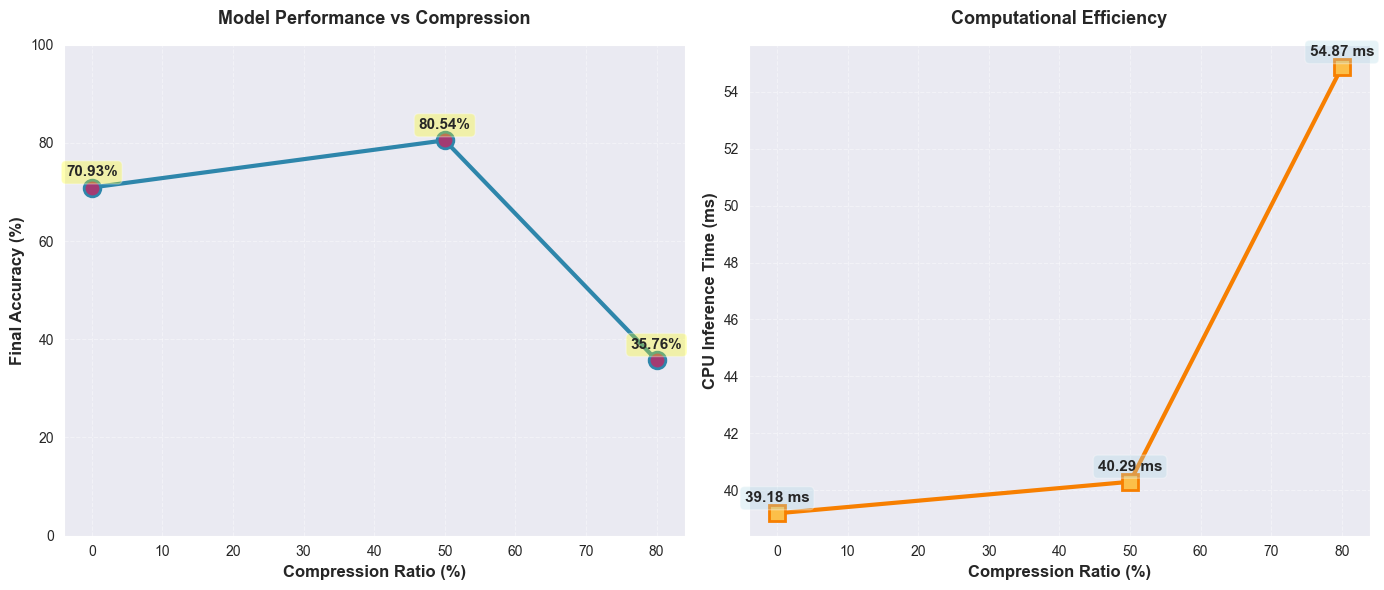


✅ Analysis Complete!


In [7]:
# ==============================================================================
# Results Summary & Visualization
# ==============================================================================

results_df = pd.DataFrame(experiment_results)
print("\n📊 EXPERIMENTAL RESULTS TABLE:")
print(results_df.to_string(index=False))

# Visualization: Two-panel summary
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Panel 1: Model Performance vs Compression
ax1 = axes[0]
ax1.plot(results_df['Compression_%'], results_df['Acc_After'], 
         marker='o', markersize=12, linewidth=3, color='#2E86AB',
         markerfacecolor='#A23B72', markeredgewidth=2)
ax1.set_xlabel('Compression Ratio (%)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Final Accuracy (%)', fontsize=12, fontweight='bold')
ax1.set_title('Model Performance vs Compression', fontsize=13, fontweight='bold', pad=15)
ax1.set_ylim([0, 100])
ax1.grid(True, alpha=0.4, linestyle='--')

# Add value labels with better positioning
for _, row in results_df.iterrows():
    ax1.annotate(f"{row['Acc_After']:.2f}%", 
                xy=(row['Compression_%'], row['Acc_After']),
                xytext=(0, 8), textcoords='offset points',
                ha='center', fontsize=11, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.3))

# Panel 2: Computational Efficiency
ax2 = axes[1]
ax2.plot(results_df['Compression_%'], results_df['Latency_ms'],
         marker='s', markersize=12, linewidth=3, color='#F77F00',
         markerfacecolor='#FCBF49', markeredgewidth=2)
ax2.set_xlabel('Compression Ratio (%)', fontsize=12, fontweight='bold')
ax2.set_ylabel('CPU Inference Time (ms)', fontsize=12, fontweight='bold')
ax2.set_title('Computational Efficiency', fontsize=13, fontweight='bold', pad=15)
ax2.grid(True, alpha=0.4, linestyle='--')

# Add value labels with better positioning
for _, row in results_df.iterrows():
    ax2.annotate(f"{row['Latency_ms']:.2f} ms",
                xy=(row['Compression_%'], row['Latency_ms']),
                xytext=(0, 8), textcoords='offset points',
                ha='center', fontsize=11, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.3))

plt.tight_layout()
plt.show()

print("\n✅ Analysis Complete!")